We start by interpolating the thermophysical properties of the solid:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from deepxde.backend import tf
import seaborn as sns
sns.set_context('talk')
%matplotlib inline

import deepxde as dde

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



Defining the geometry of the powderbed:

In [2]:
dde.config.set_default_float("float64")
dde.config.set_random_seed(12345)

x_max = 1e-3
y_max = 0.23e-3
z_max = 0.1e-3

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0), (x_max, y_max, z_max))

Set the default float type to float64


Defining the time and the domian:

In [3]:
t_max = 0.002

time = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

Defining the other properties:

In [4]:
A = 0.09
D = 140e-6
R = D/2
P = 250
v = 200e-3
T_0 = 273.15

Defining the top boundary neglecting the convection and radiation:

defining the pde system:

In [5]:
def pde_system(X, output):
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 3)
    
    molten = T > 1693
    
    k = (11.82+1.06e-2*T)
    c = (330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3)
    rho = 7800.0*T**0
    
    k_eff = tf.where(molten, k, 0.6*k)
    rho_eff = tf.where(molten, rho, 0.6*rho)
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2)
    
    f_T = dT_dt - diff_T/(rho_eff*c)# + 272e3/(c**2*rho)*tf.cast(molten, 'float64')
        
    return f_T

def dummy(X, output):
    return output

Defining initial and boundary conditions:

In [6]:
def top_bc(X, Y):
    
    molten = Y > 1693
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    k = (11.82+1.06e-2*Y)
    k_eff =  k_eff = tf.where(molten, k, 0.6*k)
    return 2*A*P/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)/k_eff

ic = dde.icbc.IC(domain, lambda on_initial: 20.0 + T_0, lambda _, on_initial: on_initial)
#top = dde.icbc.NeumannBC(domain, top_bc(x), lambda on_boundary, x: on_boundary and np.isclose(x[2], z))
top = dde.icbc.RobinBC(domain, lambda X, Y : top_bc(X, Y), lambda x, on_boundary: on_boundary and np.isclose(x[2], z_max, atol=z_max/20))
sides = dde.icbc.DirichletBC(domain, lambda X : 20.0 + T_0, lambda x, on_boundary: on_boundary and not np.isclose(x[2], z_max, atol=z_max/20))

creating the dataset:

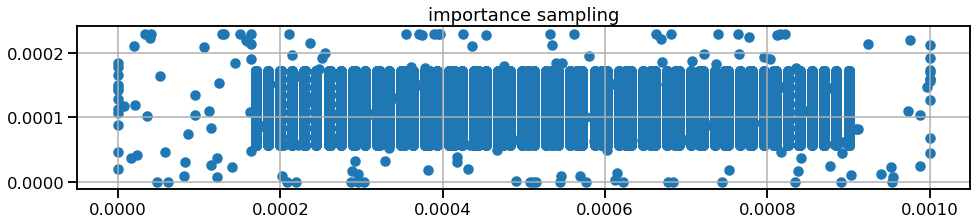

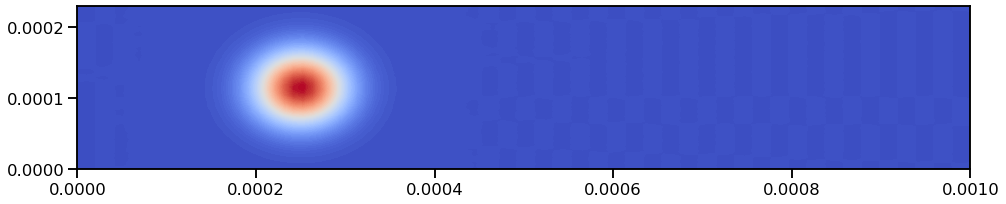

In [7]:
#setting training points at the important part of the boundary
x_lin = np.linspace(0.17*x_max, 0.9*x_max, 25)
y_lin = np.linspace(0.25*y_max, 0.75*y_max, 10)
z_lin = np.linspace(0.5*z_max, 0.95*z_max, 4)
t_lin = np.linspace(0*1*t_max, t_max, 10)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, z_lin, t_lin)
X_int = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

x_lin_bound = np.linspace(0.17*x_max, 0.9*x_max, 50)
y_lin_bound = np.linspace(0.25*y_max, 0.75*y_max, 20)
xx_bound, yy_bound, zz_bound, tt_bound = np.meshgrid(x_lin_bound, y_lin_bound, z_max, t_lin)
X_bound = np.vstack((np.ravel(xx_bound), np.ravel(yy_bound), np.ravel(zz_bound), np.ravel(tt_bound))).T

X = np.concatenate([X_int, X_bound])

data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top, sides],
                       num_domain = 100,
                       num_initial = 0,
                       num_boundary = 100,
                       train_distribution="pseudo",
                       num_test = 1e4,
                       anchors=X)

points = data.train_points().T
    
plt.figure(figsize = (16, 3))
plt.scatter(points[0], points[1])
#plt.colorbar()
plt.title('importance sampling')
plt.grid()

def top_bc_test(X):
    
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    return 2*A*P/(np.pi*R**2)*np.exp(-2*r_sq/R**2)

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [0])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
plot_data = griddata((np.ravel(xx), np.ravel(yy)), top_bc_test(X)[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, plot_data, 100, cmap=plt.cm.coolwarm)
#plt.colorbar()

In [8]:
x_max

0.001

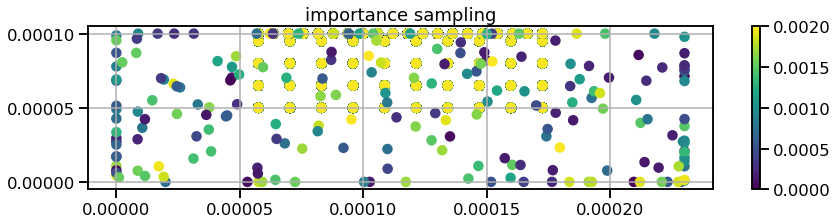

In [9]:
plt.figure(figsize = (14, 3))
plt.scatter(points[1], points[2], c = points[3])
plt.colorbar()
plt.title('importance sampling')
plt.grid()

In [10]:
#net = dde.nn.FNN([4] + [50] * 20 + [1], "sin", "Glorot normal")
#activation = f"LAAF-{1} sin" 
net = dde.nn.MsFFN([4] + [20] * 10 + [1], 'sin', "Glorot normal", sigmas = [1])

def feature_transform(X):
    return tf.concat(
        [X[:, 0:1]/x_max, 
         X[:, 1:2]/y_max,
         X[:, 2:3]/z_max,
         X[:, 3:4]/t_max], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    Temperature = Y
    T_new = 20.0 + T_0 + Temperature*3000e1*t
    return tf.concat(T_new, axis = 1)
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)

Compiling model...
Building Multiscale Fourier Feature Network...


/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
2022-07-07 16:32:22.455878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 16:32:22.490610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 16:32:22.491065: I tensorflow/stream_execu

'compile' took 4.960990 s



In [11]:
losshistory, train_state = model.train(epochs=0, display_every=1000, batch_size = 2000)
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([1, 1, 1])
resampler = dde.callbacks.PDEResidualResampler(100)

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.22e+08, 4.41e+15, 6.30e+01]    [2.50e+08, 4.41e+15, 6.30e+01]    []  

Best model at step 0:
  train loss: 4.41e+15
  test loss: 4.41e+15
  test metric: []

'train' took 1.918629 s



In [13]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-30, gtol=1e-30, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler], batch_size = 100)

Compiling model...
'compile' took 4.251174 s

Training model...

316       [1.28e-01, 1.01e+02, 9.52e+01]    [1.60e-01, 1.01e+02, 9.52e+01]    []  
400       [9.98e-01, 9.65e+01, 9.67e-01]                                          
500       [2.94e+00, 7.75e+01, 6.25e-01]                                          
600       [3.94e+00, 6.34e+01, 7.55e-01]                                          
700       [4.33e+00, 5.34e+01, 6.06e-01]                                          
800       [4.30e+00, 4.71e+01, 5.38e-01]                                          
900       [4.36e+00, 4.50e+01, 4.11e-01]                                          
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 49.755916
  Number of iterations: 490
  Number of functions evaluations: 651
967       [4.36e+00, 4.50e+01, 4.11e-01]    [2.47e+00, 4.50e+01, 4.11e-01]    []  

Best model at step 967:
  train loss: 4.98e+01
  test loss: 

In [21]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-30, gtol=1e-30, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler], batch_size = 100)

Compiling model...
'compile' took 4.328988 s

Training model...

Step      Train loss                        Test loss                         Test metric
967       [4.36e+00, 4.50e+01, 4.11e-01]    [2.47e+00, 4.50e+01, 4.11e-01]    []  
1000      [4.36e+00, 4.50e+01, 4.11e-01]                                          
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 49.755916
  Number of iterations: 5
  Number of functions evaluations: 124
1091      [4.36e+00, 4.50e+01, 4.11e-01]    [2.47e+00, 4.50e+01, 4.11e-01]    []  

Best model at step 1091:
  train loss: 4.98e+01
  test loss: 4.79e+01
  test metric: []

'train' took 39.877616 s



In [22]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2])
model.compile('adam',lr = 1e-4, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100, callbacks = [resampler], batch_size = 4000)

Compiling model...
'compile' took 5.465478 s

Training model...

Step      Train loss                        Test loss                         Test metric
1091      [4.36e+00, 4.50e+01, 4.11e-01]    [2.47e+00, 4.50e+01, 4.11e-01]    []  
1100      [5.01e+00, 4.56e+01, 1.05e+00]    [2.66e+00, 4.56e+01, 1.05e+00]    []  
1200      [3.80e+00, 4.49e+01, 3.00e-01]    [1.80e+00, 4.49e+01, 3.00e-01]    []  
1300      [4.31e+00, 4.48e+01, 2.82e-01]    [1.45e+00, 4.48e+01, 2.82e-01]    []  
1400      [4.42e+00, 4.47e+01, 2.78e-01]    [1.39e+00, 4.47e+01, 2.78e-01]    []  
1500      [3.60e+00, 4.45e+01, 2.45e-01]    [1.36e+00, 4.45e+01, 2.45e-01]    []  
1600      [3.20e+00, 4.43e+01, 2.43e-01]    [1.21e+00, 4.43e+01, 2.43e-01]    []  
1700      [3.40e+00, 4.42e+01, 2.21e-01]    [9.99e-01, 4.42e+01, 2.21e-01]    []  
1800      [3.61e+00, 4.41e+01, 2.00e-01]    [1.03e+00, 4.41e+01, 2.00e-01]    []  
1900      [3.13e+00, 4.40e+01, 1.98e-01]    [9.74e-01, 4.40e+01, 1.98e-01]    []  
2000      [3.44

In [27]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-30, gtol=1e-30, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler], batch_size = 100)

Compiling model...
'compile' took 5.387563 s

Training model...

Step      Train loss                        Test loss                         Test metric
2091      [3.03e+00, 4.38e+01, 2.11e-01]    [9.09e-01, 4.38e+01, 2.11e-01]    []  
2100      [3.04e+00, 4.38e+01, 2.09e-01]                                          
2200      [2.59e+00, 4.23e+01, 1.79e-01]                                          
2300      [2.59e+00, 4.23e+01, 1.79e-01]                                          
2400      [2.17e+00, 4.13e+01, 2.40e-01]                                          
2500      [2.24e+00, 3.93e+01, 1.81e-01]                                          
2600      [2.23e+00, 3.93e+01, 1.80e-01]                                          
2700      [2.14e+00, 3.94e+01, 1.86e-01]                                          
2800      [2.15e+00, 3.81e+01, 1.94e-01]                                          
2900      [2.03e+00, 3.64e+01, 1.35e-01]                                          
3000      [2.15

In [32]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2])
model.compile('adam',lr = 1e-4, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100, callbacks = [resampler], batch_size = 4000)

Compiling model...
'compile' took 6.394833 s

Training model...

Step      Train loss                        Test loss                         Test metric
3648      [2.00e+00, 3.08e+01, 1.18e-01]    [5.97e-01, 3.08e+01, 1.18e-01]    []  
3700      [1.99e+00, 3.11e+01, 1.22e-01]    [5.47e-01, 3.11e+01, 1.22e-01]    []  
3800      [4.34e+00, 3.14e+01, 1.36e-01]    [5.89e-01, 3.14e+01, 1.36e-01]    []  
3900      [1.92e+00, 3.09e+01, 1.11e-01]    [4.70e-01, 3.09e+01, 1.11e-01]    []  
4000      [2.04e+00, 3.08e+01, 7.85e-02]    [4.94e-01, 3.08e+01, 7.85e-02]    []  
4100      [2.16e+00, 3.08e+01, 7.19e-02]    [5.20e-01, 3.08e+01, 7.19e-02]    []  
4200      [2.72e+00, 3.08e+01, 6.22e-02]    [7.03e-01, 3.08e+01, 6.22e-02]    []  
4300      [1.86e+00, 3.08e+01, 9.01e-02]    [5.48e-01, 3.08e+01, 9.01e-02]    []  
4400      [2.32e+00, 3.08e+01, 6.16e-02]    [6.23e-01, 3.08e+01, 6.16e-02]    []  
4500      [2.12e+00, 3.08e+01, 9.04e-02]    [5.09e-01, 3.08e+01, 9.04e-02]    []  
4600      [2.52

In [33]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-30, gtol=1e-30, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler], batch_size = 100)

Compiling model...
'compile' took 5.178719 s

Training model...

Step      Train loss                        Test loss                         Test metric
4648      [1.82e+00, 3.07e+01, 8.25e-02]    [5.20e-01, 3.07e+01, 8.25e-02]    []  
4700      [1.82e+00, 3.07e+01, 8.24e-02]                                          
4800      [1.82e+00, 3.07e+01, 8.24e-02]                                          
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 32.623460
  Number of iterations: 13
  Number of functions evaluations: 230
4878      [1.82e+00, 3.07e+01, 8.24e-02]    [5.20e-01, 3.07e+01, 8.24e-02]    []  

Best model at step 4878:
  train loss: 3.26e+01
  test loss: 3.13e+01
  test metric: []

'train' took 69.168641 s



In [42]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2])
model.compile('adam',lr = 1e-4, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 2000, display_every=100, callbacks = [resampler], batch_size = 4000)

Compiling model...
'compile' took 5.917825 s

Training model...

Step      Train loss                        Test loss                         Test metric
4878      [1.82e+00, 3.07e+01, 8.24e-02]    [5.20e-01, 3.07e+01, 8.24e-02]    []  
4900      [2.01e+00, 3.11e+01, 2.74e-01]    [4.48e-01, 3.11e+01, 2.74e-01]    []  
5000      [1.90e+00, 3.07e+01, 8.25e-02]    [5.81e-01, 3.07e+01, 8.25e-02]    []  
5100      [1.93e+00, 3.07e+01, 8.21e-02]    [5.80e-01, 3.07e+01, 8.21e-02]    []  
5200      [2.18e+00, 3.07e+01, 8.95e-02]    [5.54e-01, 3.07e+01, 8.95e-02]    []  
5300      [2.23e+00, 3.07e+01, 8.15e-02]    [5.06e-01, 3.07e+01, 8.15e-02]    []  
5400      [1.76e+00, 3.07e+01, 8.63e-02]    [5.05e-01, 3.07e+01, 8.63e-02]    []  
5500      [2.05e+00, 3.07e+01, 6.65e-02]    [6.28e-01, 3.07e+01, 6.65e-02]    []  
5600      [2.37e+00, 3.06e+01, 8.34e-02]    [5.95e-01, 3.06e+01, 8.34e-02]    []  
5700      [1.51e+00, 3.06e+01, 7.41e-02]    [5.53e-01, 3.06e+01, 7.41e-02]    []  
5800      [1.99

In [58]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2])
model.compile('adam',lr = 5e-4, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 2000, display_every=100, callbacks = [resampler], batch_size = 4000)

Compiling model...
'compile' took 4.582656 s

Training model...

Step      Train loss                        Test loss                         Test metric
6878      [1.61e+00, 3.02e+01, 4.86e-02]    [7.51e-01, 3.02e+01, 4.86e-02]    []  
6900      [1.98e+01, 7.69e+01, 5.22e-01]    [1.35e+00, 7.69e+01, 5.22e-01]    []  
7000      [3.65e+00, 4.74e+01, 1.00e-01]    [3.46e+00, 4.74e+01, 1.00e-01]    []  
7100      [2.75e+00, 4.31e+01, 3.22e-02]    [1.05e+00, 4.31e+01, 3.22e-02]    []  
7200      [2.08e+00, 3.99e+01, 4.06e-02]    [7.75e-01, 3.99e+01, 4.06e-02]    []  
7300      [2.49e+00, 3.78e+01, 4.31e-02]    [7.88e-01, 3.78e+01, 4.31e-02]    []  
7400      [1.88e+00, 3.65e+01, 1.91e-01]    [7.61e-01, 3.65e+01, 1.91e-01]    []  
7500      [2.19e+00, 3.53e+01, 6.69e-02]    [7.29e-01, 3.53e+01, 6.69e-02]    []  
7600      [1.78e+00, 3.44e+01, 9.61e-02]    [6.32e-01, 3.44e+01, 9.61e-02]    []  
7700      [1.90e+00, 3.32e+01, 9.91e-02]    [6.09e-01, 3.32e+01, 9.91e-02]    []  
7800      [1.88

In [59]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-30, gtol=1e-30, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler], batch_size = 100)

Compiling model...
'compile' took 6.075295 s

Training model...

Step      Train loss                        Test loss                         Test metric
8878      [1.94e+00, 3.08e+01, 6.56e-02]    [5.64e-01, 3.08e+01, 6.56e-02]    []  
8900      [1.91e+00, 3.08e+01, 8.52e-02]                                          
9000      [1.91e+00, 3.08e+01, 9.12e-02]                                          
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 32.741847
  Number of iterations: 26
  Number of functions evaluations: 172
9050      [1.91e+00, 3.07e+01, 9.12e-02]    [4.12e-01, 3.07e+01, 9.12e-02]    []  

Best model at step 6878:
  train loss: 3.19e+01
  test loss: 3.10e+01
  test metric: []

'train' took 57.610890 s



In [72]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2])
model.compile('adam',lr = 1e-4, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 2000, display_every=100, callbacks = [resampler], batch_size = 4000)

Compiling model...
'compile' took 8.429521 s

Training model...

Step      Train loss                        Test loss                         Test metric
9050      [1.91e+00, 3.07e+01, 9.12e-02]    [4.12e-01, 3.07e+01, 9.12e-02]    []  
9100      [1.86e+00, 3.08e+01, 8.88e-02]    [4.29e-01, 3.08e+01, 8.88e-02]    []  
9200      [1.68e+00, 3.07e+01, 7.85e-02]    [4.73e-01, 3.07e+01, 7.85e-02]    []  
9300      [1.75e+00, 3.07e+01, 5.09e-02]    [5.75e-01, 3.07e+01, 5.09e-02]    []  
9400      [1.40e+00, 3.07e+01, 5.23e-02]    [5.69e-01, 3.07e+01, 5.23e-02]    []  
9500      [1.79e+00, 3.07e+01, 7.34e-02]    [5.05e-01, 3.07e+01, 7.34e-02]    []  
9600      [1.49e+00, 3.06e+01, 8.17e-02]    [4.94e-01, 3.06e+01, 8.17e-02]    []  
9700      [2.06e+00, 3.07e+01, 5.64e-02]    [6.59e-01, 3.07e+01, 5.64e-02]    []  
9800      [1.97e+00, 3.06e+01, 7.03e-02]    [5.47e-01, 3.06e+01, 7.03e-02]    []  
9900      [2.43e+00, 3.07e+01, 8.42e-02]    [6.13e-01, 3.07e+01, 8.42e-02]    []  
10000     [2.25

In [73]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-30, gtol=1e-30, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler], batch_size = 100)

Compiling model...
'compile' took 7.387480 s

Training model...

Step      Train loss                        Test loss                         Test metric
11050     [2.03e+00, 2.98e+01, 7.47e-02]    [5.94e-01, 2.98e+01, 7.47e-02]    []  
11100     [1.87e+00, 2.95e+01, 4.64e-02]                                          
11200     [1.63e+00, 2.93e+01, 3.37e-02]                                          
11300     [1.61e+00, 2.92e+01, 3.38e-02]                                          
11400     [1.46e+00, 2.86e+01, 3.40e-02]                                          
11500     [1.44e+00, 2.86e+01, 3.21e-02]                                          
11600     [1.45e+00, 2.86e+01, 3.32e-02]                                          
INFO:tensorflow:Optimization terminated with:
  Message: ABNORMAL_TERMINATION_IN_LNSRCH
  Objective function value: 30.067271
  Number of iterations: 217
  Number of functions evaluations: 591
11641     [1.45e+00, 2.86e+01, 3.32e-02]    [1.14e+00, 2.86e+01, 3.32e-

In [75]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2])
model.compile('adam',lr = 1e-4, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 2000, display_every=100, callbacks = [resampler], batch_size = 4000)

Compiling model...
'compile' took 7.969350 s

Training model...

Step      Train loss                        Test loss                         Test metric
11641     [1.45e+00, 2.86e+01, 3.32e-02]    [1.14e+00, 2.86e+01, 3.32e-02]    []  
11700     [1.46e+00, 2.87e+01, 3.40e-02]    [1.33e+00, 2.87e+01, 3.40e-02]    []  
11800     [2.69e+00, 2.87e+01, 8.43e-02]    [1.25e+00, 2.87e+01, 8.43e-02]    []  
11900     [2.25e+00, 2.88e+01, 6.36e-02]    [1.19e+00, 2.88e+01, 6.36e-02]    []  
12000     [2.96e+00, 2.90e+01, 6.50e-02]    [1.16e+00, 2.90e+01, 6.50e-02]    []  
12100     [1.65e+00, 2.88e+01, 6.07e-02]    [9.92e-01, 2.88e+01, 6.07e-02]    []  
12200     [1.58e+00, 2.87e+01, 5.29e-02]    [9.91e-01, 2.87e+01, 5.29e-02]    []  
12300     [2.03e+00, 2.87e+01, 6.02e-02]    [9.76e-01, 2.87e+01, 6.02e-02]    []  
12400     [1.36e+00, 2.86e+01, 4.37e-02]    [9.44e-01, 2.86e+01, 4.37e-02]    []  
12500     [1.84e+00, 2.87e+01, 7.19e-02]    [9.29e-01, 2.87e+01, 7.19e-02]    []  
12600     [2.38

In [85]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2])
model.compile('adam',lr = 1e-5, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 6000, display_every=100, callbacks = [resampler], batch_size = 4000)

Compiling model...
'compile' took 7.337614 s

Training model...

Step      Train loss                        Test loss                         Test metric
13641     [1.84e+00, 2.85e+01, 4.44e-02]    [8.59e-01, 2.85e+01, 4.44e-02]    []  
13700     [1.80e+00, 2.85e+01, 4.31e-02]    [8.51e-01, 2.85e+01, 4.31e-02]    []  
13800     [1.90e+00, 2.85e+01, 5.22e-02]    [8.52e-01, 2.85e+01, 5.22e-02]    []  
13900     [1.78e+00, 2.85e+01, 5.03e-02]    [7.21e-01, 2.85e+01, 5.03e-02]    []  
14000     [2.01e+00, 2.85e+01, 8.20e-02]    [7.74e-01, 2.85e+01, 8.20e-02]    []  
14100     [1.36e+00, 2.85e+01, 5.77e-02]    [7.09e-01, 2.85e+01, 5.77e-02]    []  
14200     [1.44e+00, 2.85e+01, 5.98e-02]    [7.86e-01, 2.85e+01, 5.98e-02]    []  
14300     [1.39e+00, 2.85e+01, 4.27e-02]    [9.99e-01, 2.85e+01, 4.27e-02]    []  
14400     [2.05e+00, 2.85e+01, 4.14e-02]    [9.67e-01, 2.85e+01, 4.14e-02]    []  
14500     [1.67e+00, 2.85e+01, 5.54e-02]    [7.30e-01, 2.85e+01, 5.54e-02]    []  
14600     [1.22

In [92]:
model.save('nice/')

INFO:tensorflow:nice/-19641.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'nice/-19641.ckpt'

In [98]:
np.save('loss_test', np.array(losshistory.loss_test))

In [99]:
np.save('loss_train', np.array(losshistory.loss_train))

In [ ]:
model.restore('nice/-19641.ckpt')

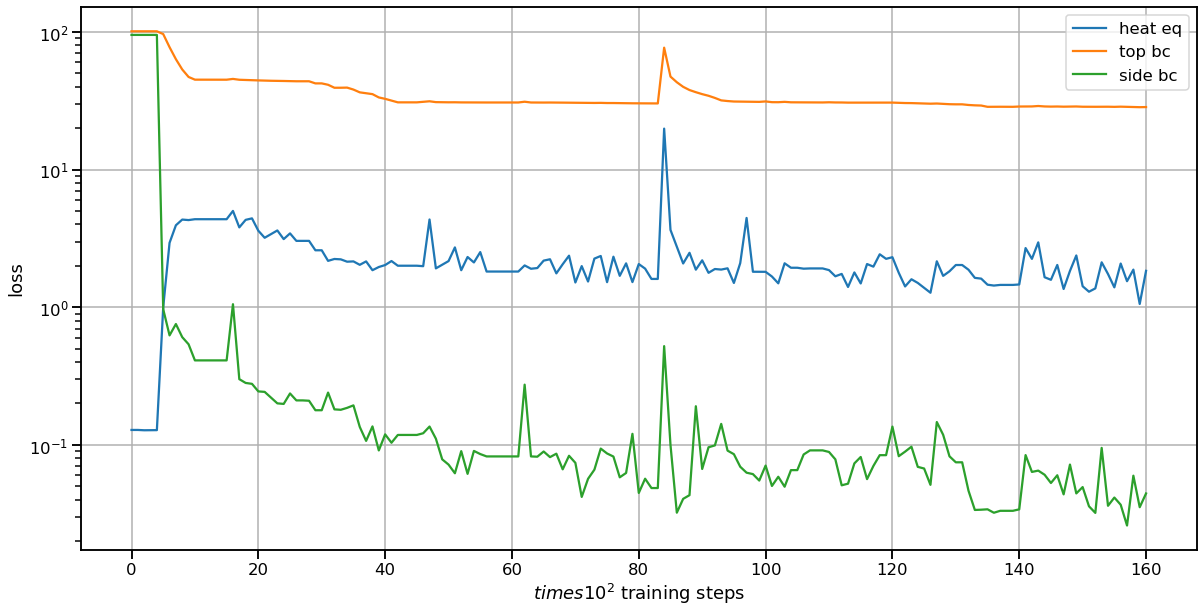

In [76]:
%matplotlib inline

loss_names = ['heat eq', 'top bc', 'side bc']
n = 1
plt.figure(figsize = (20, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.yscale('log')
plt.xlabel(r'$ times 10^2$ training steps')
plt.ylabel('loss')
plt.grid()
plt.legend()

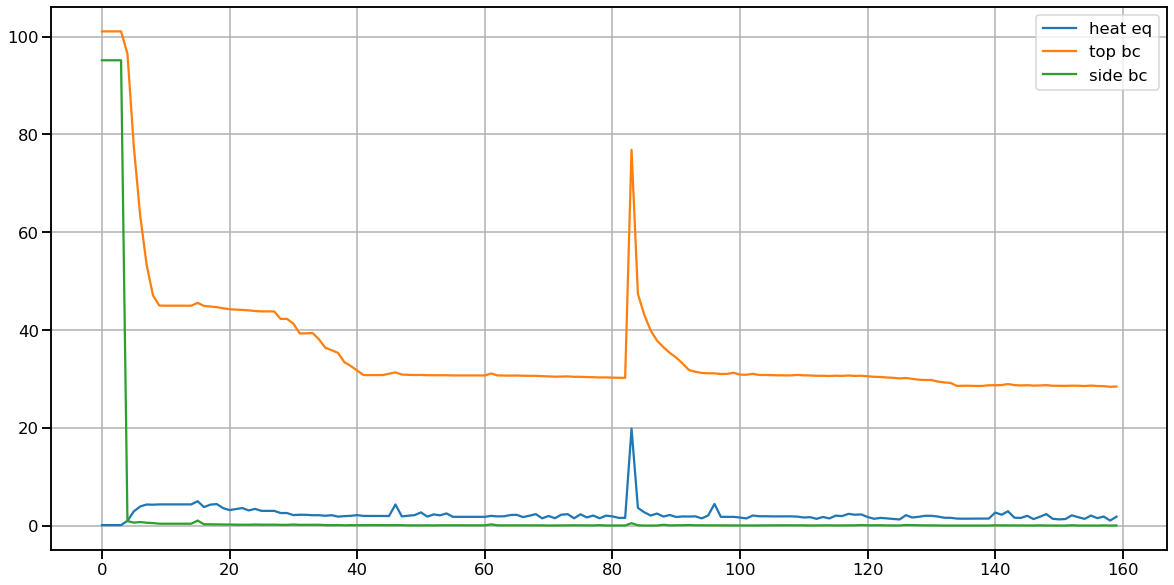

In [77]:
loss_names = ['heat eq', 'top bc', 'side bc']
n = 2
plt.figure(figsize = (20, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

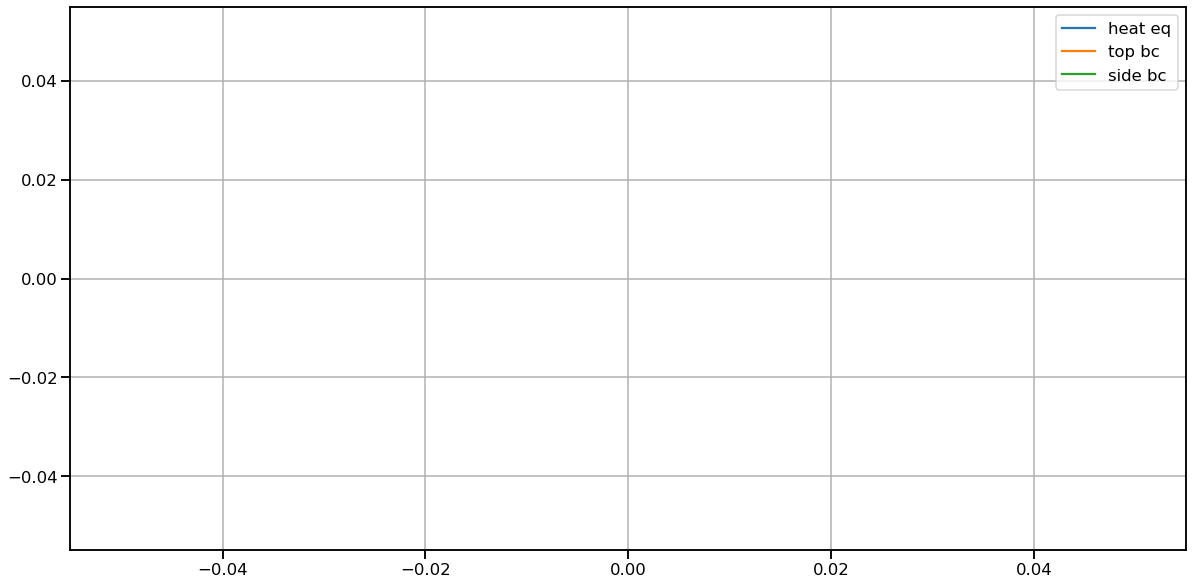

In [24]:
loss_names = ['heat eq', 'top bc', 'side bc']
n = 100
plt.figure(figsize = (20, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

<IPython.core.display.Javascript object>


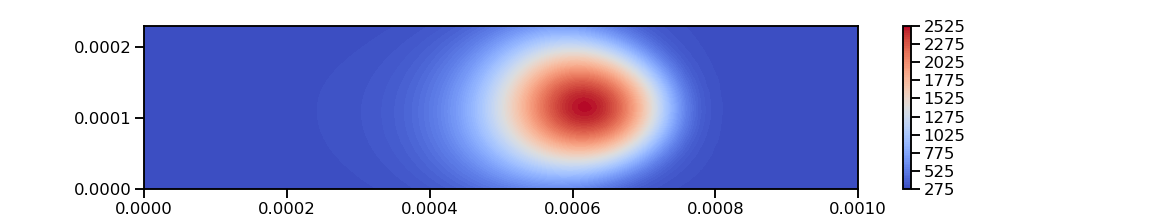

In [86]:
from scipy.interpolate import griddata

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm)
plt.colorbar()

<IPython.core.display.Javascript object>


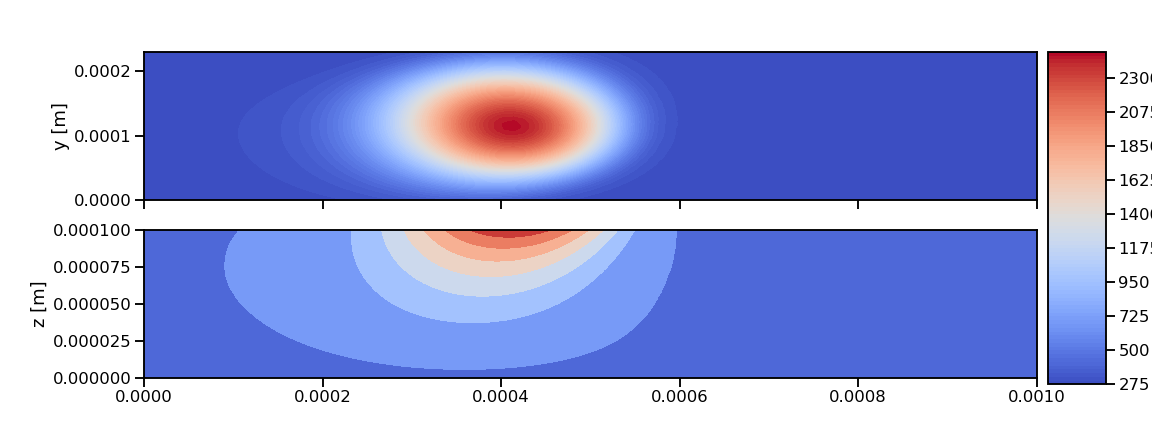

In [84]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (16, 6), sharex=True)

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
z_lin = np.linspace(0, z_max)

xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

CS = ax1.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm)
ax1.set_ylabel('y [m]')
#plt.colorbar(CS, ax = ax1)

xx2, yy2, zz2, tt2 = np.meshgrid(x_lin, [y_max/2], z_lin, [t_max])
X2 = np.vstack((np.ravel(xx2), np.ravel(yy2), np.ravel(zz2), np.ravel(tt2))).T
Y2 = model.predict(X2)

xi2 = np.linspace(xx2.min(), xx2.max(), 100)
zi2 = np.linspace(zz2.min(), zz2.max(), 100)
data2 = griddata((np.ravel(xx2), np.ravel(zz2)), Y2[:,0], (xi2[None,:], zi2[:,None]), method='cubic')

CS2 = ax2.contourf(xi2, zi2, data2, 100, cmap=plt.cm.coolwarm)
ax2.set_ylabel('z [m]')
#plt.colorbar(CS2, ax = ax2)

cbar_ax = fig.add_axes([0.91, 0.11, 0.05, 0.77])
fig.colorbar(CS, cax=cbar_ax)

def animate(i):

    xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [i/100*t_max])
    X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
    Y = model.predict(X)

    xi = np.linspace(xx.min(), xx.max(), 100)
    yi = np.linspace(yy.min(), yy.max(), 100)
    data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

    CS = ax1.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm)
    
    xx2, yy2, zz2, tt2 = np.meshgrid(x_lin, [y_max/2], z_lin, [i/100*t_max])
    X2 = np.vstack((np.ravel(xx2), np.ravel(yy2), np.ravel(zz2), np.ravel(tt2))).T
    Y2 = model.predict(X2)

    xi2 = np.linspace(xx2.min(), xx2.max(), 100)
    zi2 = np.linspace(zz2.min(), zz2.max(), 100)
    data2 = griddata((np.ravel(xx2), np.ravel(zz2)), Y2[:,0], (xi2[None,:], zi2[:,None]), method='cubic')

    CS2 = ax2.contourf(xi2, zi2, data2, intervall = 100, cmap=plt.cm.coolwarm)
            
FuncAnimation(fig, animate, frames = 100, interval=100)

<IPython.core.display.Javascript object>


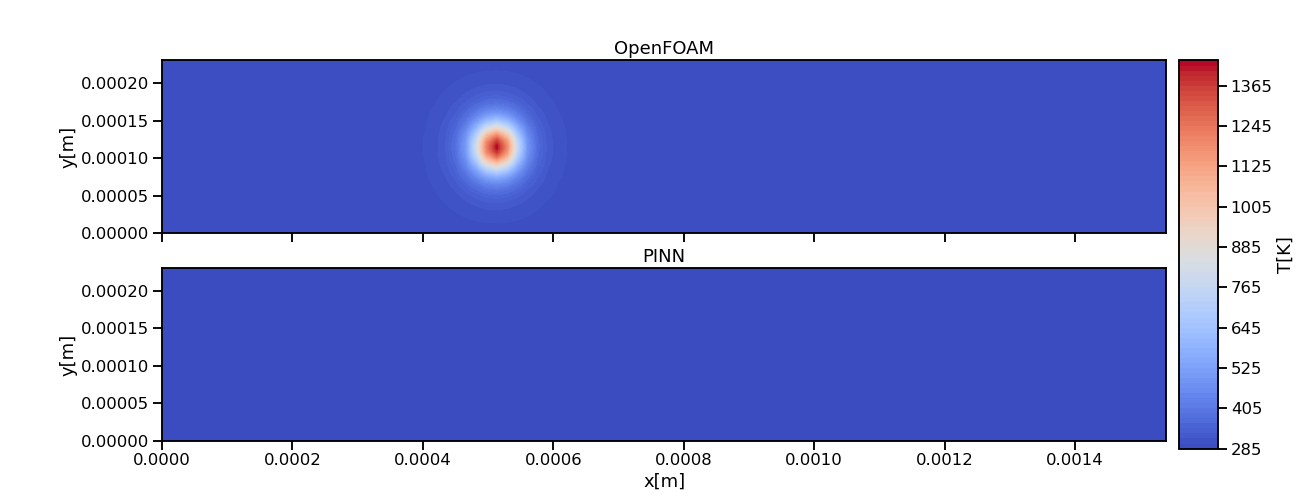

MovieWriter stderr:
pictures/video.mp4: No such file or directory



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1296x504', '-pix_fmt', 'rgba', '-r', '60', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'pictures/video.mp4']' returned non-zero exit status 1.

In [29]:
slice_data = np.genfromtxt('of_phase/slice1/slice_124.csv', delimiter = ',',skip_header = True)

x = slice_data[:,0]
y = slice_data[:,1]
z = slice_data[:,2]
T = slice_data[:,3]

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (18, 7), sharex=True)

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm)
ax1.set_ylabel('y[m]')
ax1.set_title('OpenFOAM')
ax2.set_ylabel('y[m]')
ax2.set_xlabel('x[m]')
ax2.set_title('PINN')

#cbar = plt.colorbar(im, ax = ax1)
#cbar.ax.set_ylabel('T[K]')
#cbar2 = plt.colorbar(im, ax = ax2)
#cbar2.ax.set_ylabel('T[K]')

cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('T[K]')

def animate(i):
    
    slice_data = np.genfromtxt('of_phase/slice1/slice_{}.csv'.format(i), delimiter = ',',skip_header = True)
    T = slice_data[:,3]
    
    #xx, yy, zz, tt = np.meshgrid(x, y, [z.max], [(i+1)/125*t_max])
    X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max/125*(i+1))).T
    Y = model.predict(X)
    
    Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
    T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')
    
    im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm)
    CS = ax2.contourf(xi, yi, T_pred, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20, vmax = 1500)
            
anim = FuncAnimation(fig, animate, frames = 125, interval = 300)
from matplotlib.animation import FFMpegWriter

writervideo = FFMpegWriter(fps=60)
anim.save('pictures/video.mp4', writer=writervideo)

<IPython.core.display.Javascript object>


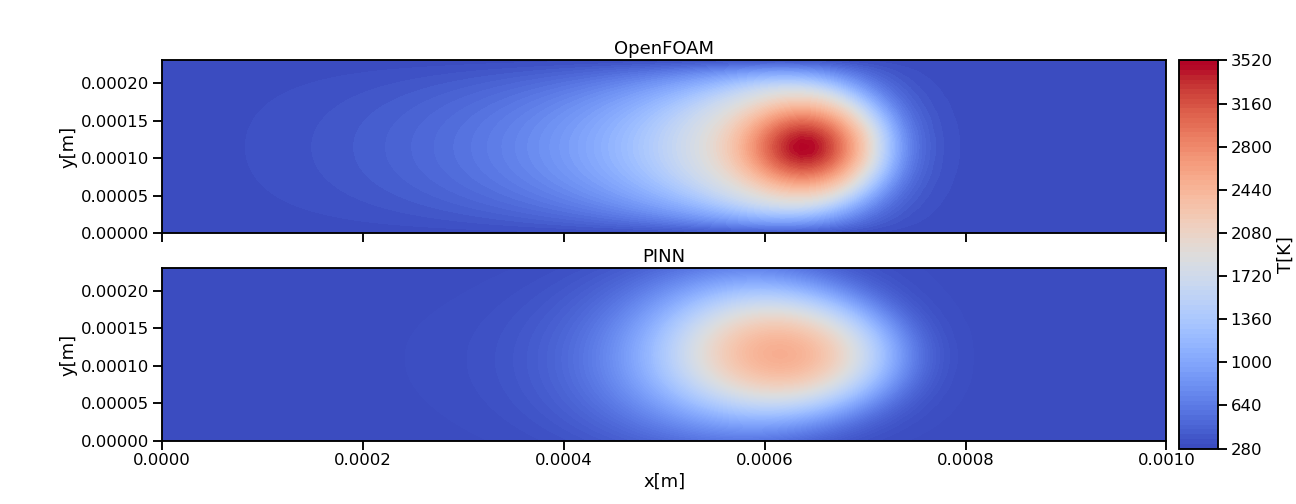

In [91]:
i = 199
dt = t_max/200
end_data = np.genfromtxt('of_test/slices/slice_dat_{}.csv'.format(i), delimiter = ',',skip_header = True)

#end_data = np.genfromtxt('of_test/end_slice.csv', delimiter = ',',skip_header = True)
x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (18, 7), sharex=True)

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

ax1.set_ylabel('y[m]')
ax1.set_title('OpenFOAM')
ax2.set_ylabel('y[m]')
ax2.set_xlabel('x[m]')
ax2.set_title('PINN')

#cbar = plt.colorbar(im, ax = ax1)
#cbar.ax.set_ylabel('T[K]')
#cbar2 = plt.colorbar(im, ax = ax2)
#cbar2.ax.set_ylabel('T[K]')

X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*dt*i)).T
Y = model.predict(X)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')
    
im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm, vmin = T.min(), vmax = T.max())
CS = ax2.contourf(xi, yi, T_pred, 100, cmap=plt.cm.coolwarm, vmin = T.min(), vmax = T.max())

cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('T[K]')
plt.show()

<IPython.core.display.Javascript object>


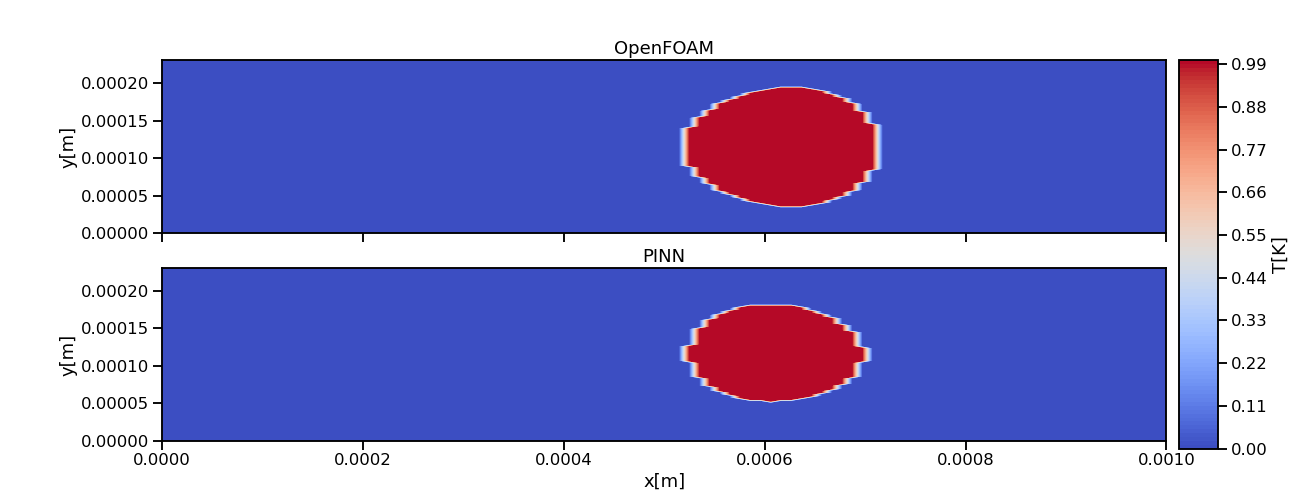

Text(0, 0.5, 'T[K]')

In [88]:
fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (18, 7), sharex=True)

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

ax1.set_ylabel('y[m]')
ax1.set_title('OpenFOAM')
ax2.set_ylabel('y[m]')
ax2.set_xlabel('x[m]')
ax2.set_title('PINN')

#cbar = plt.colorbar(im, ax = ax1)
#cbar.ax.set_ylabel('T[K]')
#cbar2 = plt.colorbar(im, ax = ax2)
#cbar2.ax.set_ylabel('T[K]')

X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max)).T
Y = model.predict(X)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')
    
im = ax1.contourf(xi, yi, Ti > 1693, 100, cmap=plt.cm.coolwarm)
CS = ax2.contourf(xi, yi, T_pred> 1693, 100, cmap=plt.cm.coolwarm)

cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('T[K]')

<IPython.core.display.Javascript object>


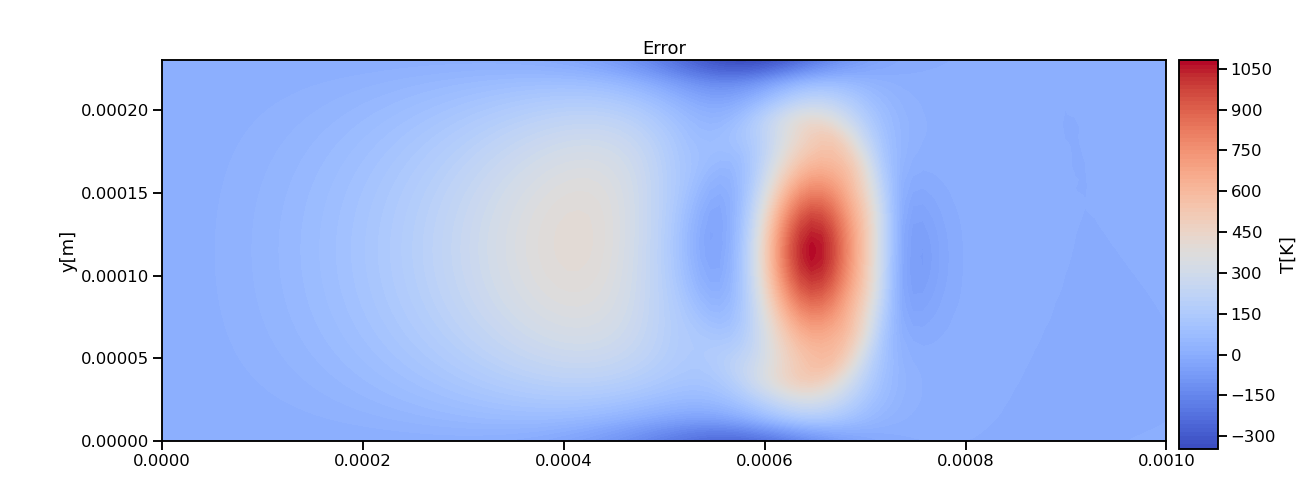

Text(0, 0.5, 'T[K]')

In [89]:
fig, (ax1) = plt.subplots(ncols = 1, nrows = 1, figsize = (18, 7))

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

ax1.set_ylabel('y[m]')
ax1.set_title('Error')
ax2.set_ylabel('y[m]')
ax2.set_xlabel('x[m]')
ax2.set_title('PINN')

#cbar = plt.colorbar(im, ax = ax1)
#cbar.ax.set_ylabel('T[K]')
#cbar2 = plt.colorbar(im, ax = ax2)
#cbar2.ax.set_ylabel('T[K]')

X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max)).T
Y = model.predict(X)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')
    
im = ax1.contourf(xi, yi, Ti - T_pred, 100, cmap=plt.cm.coolwarm)

cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('T[K]')

In [48]:
T_pred.shape

(100, 100)

In [49]:
T.shape

(2196,)

In [ ]:
y.max()

In [ ]:
x_max

In [ ]:
y_max

In [ ]:
z_max

In [57]:
T.max()

3447.3

In [58]:
T_pred.max()

4691.779768083136

In [85]:
t_lin

array([0.        , 0.00022222, 0.00044444, 0.00066667, 0.00088889,
       0.00111111, 0.00133333, 0.00155556, 0.00177778, 0.002     ])

In [86]:
X

array([[2.5667e-05, 0.0000e+00, 1.0000e-04, 2.0000e-03],
       [0.0000e+00, 0.0000e+00, 1.0000e-04, 2.0000e-03],
       [2.5667e-05, 6.5714e-06, 1.0000e-04, 2.0000e-03],
       ...,
       [1.4887e-03, 2.3000e-04, 1.0000e-04, 2.0000e-03],
       [1.5143e-03, 2.3000e-04, 1.0000e-04, 2.0000e-03],
       [1.5400e-03, 2.3000e-04, 1.0000e-04, 2.0000e-03]])

In [15]:
T_pred.max()

6091.085075471046

In [71]:
2700/60

45.0